In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import string


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 


message = pd.read_csv('spam.csv')

In [2]:
message.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [3]:

message = message.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
message = message.rename(columns={"v1":"label", "v2":"text"})

In [4]:
message.describe()


label                    text
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

In [5]:
message.groupby("label").describe()


text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [6]:
message.label.value_counts()



ham     4825
spam     747
Name: label, dtype: int64

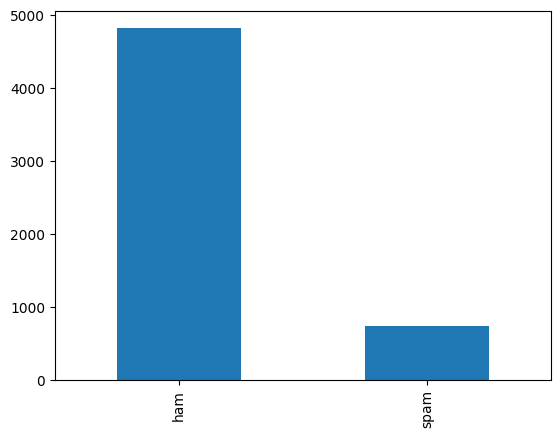

In [7]:
message.label.value_counts().plot.bar();


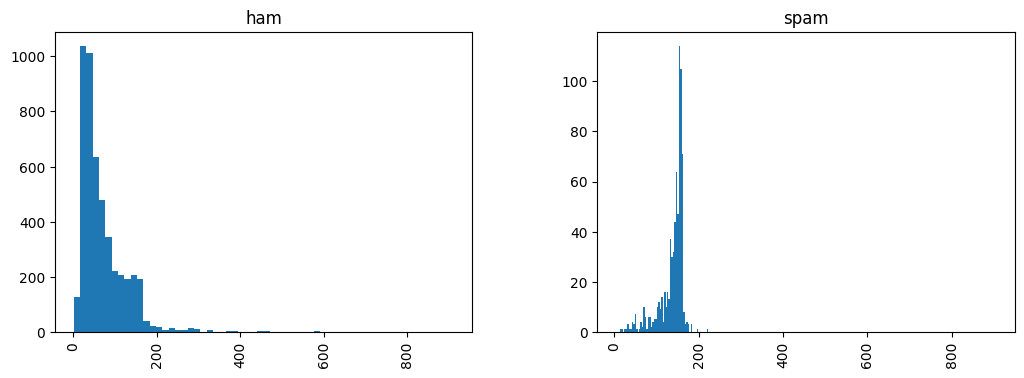

In [10]:
message.hist(column='length',by='label',bins=60,figsize=(12,4));
plt.xlim(-40,950);

In [11]:
message.length.describe()


count    5572.000000
mean       80.058327
std        59.623937
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

In [12]:
import string
mess = 'sample message!...'
nopunc=[char for char in mess if char not in string.punctuation]
nopunc=''.join(nopunc)
print(nopunc)

sample message


In [13]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('english')[0:10]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [14]:
nopunc.split()


['sample', 'message']

In [15]:
clean_message=[word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


In [16]:
clean_message

['sample', 'message']

In [17]:

def text_process(mess):
    nopunc =[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [18]:
message.head()

label                                               text  spam  length
0   ham  Go until jurong point, crazy.. Available only ...     0     111
1   ham                      Ok lar... Joking wif u oni...     0      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     1     155
3   ham  U dun say so early hor... U c already then say...     0      49
4   ham  Nah I don't think he goes to usf, he lives aro...     0      61

In [19]:
message['text'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

In [20]:
from sklearn.feature_extraction.text import CountVectorizer


In [21]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(message['text'])
print(len(bow_transformer.vocabulary_))

11301


In [22]:
message4=message['text'][3]
print(message4)

U dun say so early hor... U c already then say...


In [23]:
bow4=bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 3996)	2
  (0, 4551)	1
  (0, 5179)	1
  (0, 6118)	1
  (0, 6136)	1
  (0, 7091)	1
  (0, 9445)	2
(1, 11301)


In [24]:
messages_bow = bow_transformer.transform(message['text'])
print('Shape of Sparse Matrix: ',messages_bow.shape)
print('Amount of non-zero occurences:',messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11301)
Amount of non-zero occurences: 50193


In [25]:
sparsity =(100.0 * messages_bow.nnz/(messages_bow.shape[0]*messages_bow.shape[1]))
print('sparsity:{}'.format(round(sparsity)))

sparsity:0


In [26]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9445)	0.5391515179363724
  (0, 7091)	0.438375519235493
  (0, 6136)	0.3183143011307023
  (0, 6118)	0.2991551295536476
  (0, 5179)	0.2969195675145299
  (0, 4551)	0.26585776633899993
  (0, 3996)	0.40924708612713756


In [27]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.288863056423095
8.527076498901426


In [28]:
messages_tfidf=tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11301)


In [29]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf,message['label'])

In [30]:
print('predicted:',spam_detect_model.predict(tfidf4)[0])
print('expected:',message.label[3])

predicted: ham
expected: ham


In [31]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [32]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(message['label'],all_predictions))
print(confusion_matrix(message['label'],all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572

[[4825    0]
 [ 114  633]]


In [33]:
from sklearn.model_selection import train_test_split
msg_train,msg_test,label_train,label_test = train_test_split(message['text'],message['label'],test_size=0.2)

In [34]:
print(len(msg_train),len(msg_test),len(label_train),len(label_test))

4457 1115 4457 1115


In [35]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
   ( 'bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB()),
])

In [36]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f5ac157ff70>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [37]:
predictions = pipeline.predict(msg_test)

In [38]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98       995
        spam       0.74      1.00      0.85       120

    accuracy                           0.96      1115
   macro avg       0.87      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115



In [39]:
data = pd.read_csv('Data2.csv')
data.head()

v1                                  v2
0   ham  come and give a kiss to your papa!
1   ham                damn bro, I miss her
2   ham              I�ve been tryna tell u
3  spam    Cick here, you just won a phone!
4  spam          Suscribe to this magazine!

In [40]:
dataM = data.rename(columns={"v1":"label", "v2":"text"})
dataM

label                                text
0   ham  come and give a kiss to your papa!
1   ham                damn bro, I miss her
2   ham              I�ve been tryna tell u
3  spam    Cick here, you just won a phone!
4  spam          Suscribe to this magazine!
5   ham                That�s what she said
6   ham                 I�m tryna party man
7  spam                   Ninel Conde naked
8  spam  Call this phone to gain easy money
9   ham                      Ur wrong vato!

In [41]:
dataM['text'].head(5).apply(text_process)

0    [come, give, kiss, papa]
1           [damn, bro, miss]
2      [I�ve, tryna, tell, u]
3               [Cick, phone]
4        [Suscribe, magazine]
Name: text, dtype: object

In [42]:
dataM_bow = bow_transformer.transform(dataM['text'])
print('Shape of Sparse Matrix: ',dataM_bow.shape)
print('Amount of non-zero occurences:',dataM_bow.nnz)


Shape of Sparse Matrix:  (10, 11301)
Amount of non-zero occurences: 22


In [43]:
dataM_tfidf=tfidf_transformer.transform(dataM_bow)
print(dataM_tfidf.shape)

(10, 11301)


In [44]:
spam_detect_modelNew = MultinomialNB().fit(dataM_tfidf,dataM['label'])

In [45]:
print('predictedNew:',spam_detect_modelNew.predict(tfidf4)[0])
print('expectedNew:',dataM.label[0])

predictedNew: ham
expectedNew: ham


In [46]:
all_predictionsNew = spam_detect_modelNew.predict(dataM_tfidf)
print(all_predictionsNew)

['ham' 'ham' 'ham' 'spam' 'spam' 'ham' 'ham' 'spam' 'spam' 'ham']


In [47]:
print(classification_report(dataM['label'],all_predictionsNew))
print(confusion_matrix(dataM['label'],all_predictionsNew))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00         6
        spam       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

[[6 0]
 [0 4]]


In [48]:
msgNew_train,msgNew_test,labelNew_train,labelNew_test = train_test_split(dataM['text'],dataM['label'],test_size=0.2)
print(len(msgNew_train),len(msgNew_test),len(labelNew_train),len(labelNew_test))

8 2 8 2


In [49]:
pipeline = Pipeline([
   ( 'bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB()),
])

In [50]:
pipeline.fit(msgNew_train,labelNew_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f5ac157ff70>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [51]:
predictionsNew = pipeline.predict(msgNew_test)

In [52]:
print(classification_report(predictionsNew,labelNew_test))

              precision    recall  f1-score   support

         ham       1.00      0.50      0.67         2
        spam       0.00      0.00      0.00         0

    accuracy                           0.50         2
   macro avg       0.50      0.25      0.33         2
weighted avg       1.00      0.50      0.67         2

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b073e99d-4bae-46c0-88bf-e1468c6d08a6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>